Re-setting normalization constants
Epoch time training_loss validation_loss
     1  0.0039   0.06138490   0.07787137
   101  0.0034   0.02605961   0.01954500
   201  0.0034   0.02559551   0.02100940
   301  0.0034   0.02594384   0.01646672
   401  0.0034   0.02632545   0.02477837
   501  0.0034   0.02450716   0.01942992
   601  0.0034   0.02412384   0.01801254
   701  0.0034   0.02554820   0.01676877
   801  0.0034   0.02650171   0.01980877
   901  0.0035   0.02396138   0.01709250
  1001  0.0034   0.02346570   0.01755964
  1101  0.0039   0.02404506   0.01806888
  1201  0.0034   0.02524586   0.02192488
Total number of epochs:  1201
Final rmse validation error:  0.021924875986368313
RMSE on training data: 0.024804381733477605
RMSE on test data: 0.06014109773036551


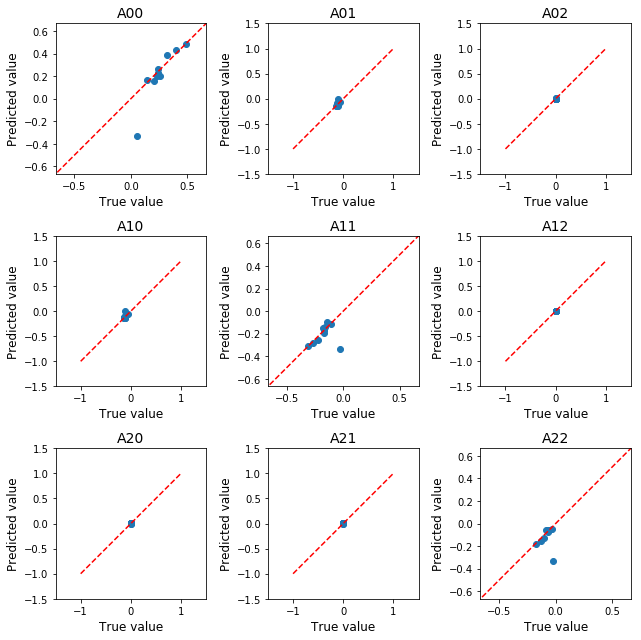

In [11]:
###############################################################
#
# Copyright 2017 Sandia Corporation. Under the terms of
# Contract DE-AC04-94AL85000 with Sandia Corporation, the
# U.S. Government retains certain rights in this software.
# This software is distributed under the BSD-3-Clause license.
#
##############################################################

import numpy as np
import matplotlib.pyplot as plt

from turbulencekepspreprocessor import TurbulenceKEpsDataProcessor
from tbnn import NetworkStructure, TBNN

"""
In this example, a Tensor Basis Neural Network (TBNN) is trained on the data for a simple turbulent channel flow.
The inputs are the mean strain rate tensor and the mean rotation rate tensor (normalized by k and epsilon).
The output is the Reynolds stress anisotropy tensor.

Data:
The channel data set is based on a profile from the channel flow DNS of Moser et al. at Re_tau=590.
The tke, epsilon, and velocity gradient are from a k-epsilon RANS of the same flow.
The Reynolds stresses are from the DNS.

Reference for DNS data: Moser, R. D., Kim, J., & Mansour, N. N. (1999).
"Direct numerical simulation of turbulent channel flow up to Re= 590". Phys. Fluids, 11(4), 943-945.

Reference for data driven turbulence modeling TBNN implementation:
Ling, J., Kurzawski, A. and Templeton, J., 2016. Reynolds averaged turbulence modelling using deep neural
networks with embedded invariance. Journal of Fluid Mechanics, 807, pp.155-166.
"""


def load_channel_data():
    """
    Loads in channel flow data
    :return:
    """

    # Load in data from channel.txt
    data = np.loadtxt('channel.txt', skiprows=4)
    k = data[:, 0]
    eps = data[:, 1]
    grad_u_flat = data[:, 2:11]
    stresses_flat = data[:, 11:]

    # Reshape grad_u and stresses to num_points X 3 X 3 arrays
    num_points = data.shape[0]
    grad_u = np.zeros((num_points, 3, 3))
    stresses = np.zeros((num_points, 3, 3))
    for i in xrange(3):
        for j in xrange(3):
            grad_u[:, i, j] = grad_u_flat[:, i*3+j]
            stresses[:, i, j] = stresses_flat[:, i*3+j]
    return k, eps, grad_u, stresses


def plot_results(predicted_stresses, true_stresses):
    """
    Create a plot with 9 subplots.  Each subplot shows the predicted vs the true value of that
    stress anisotropy component.  Correct predictions should lie on the y=x line (shown with
    red dash).
    :param predicted_stresses: Predicted Reynolds stress anisotropy (from TBNN predictions)
    :param true_stresses: True Reynolds stress anisotropy (from DNS)
    """
    fig = plt.figure(figsize=(9,9))
    fig.patch.set_facecolor('white')
    on_diag = [0, 4, 8]
    for i in xrange(9):
            #plt.title('Modified code graph')
            plt.subplot(3, 3, i+1)
            ax = fig.gca()
            ax.set_aspect('equal')
            plt.plot([-1., 1.], [-1., 1.], 'r--')
            plt.scatter(true_stresses[:, i], predicted_stresses[:, i])
            plt.xlabel('True value', fontsize=12)
            plt.ylabel('Predicted value', fontsize=12)
            idx_1 = i / 3
            idx_2 = i % 3
            plt.title('A' + str(idx_1) + str(idx_2), fontsize=14)
            if i in on_diag:
                plt.xlim([-2./3., 2./3.])
                plt.ylim([-2./3., 2./3.])
            else:
                plt.xlim([-1.5, 1.5])
                plt.ylim([-1.5, 1.5])
    plt.tight_layout()
    plt.show()


def main():
    # Define parameters:
    num_layers = 1 #CHANGE 1 # Number of hidden layers in the TBNN
    num_nodes = 15 #CHANGE 2  # Number of nodes per hidden layer
    max_epochs = 4000 #CHANGE 3 # Max number of epochs during training
    min_epochs = 1000  # Min number of training epochs required
    interval = 100  # Frequency at which convergence is checked
    average_interval = 4  # Number of intervals averaged over for early stopping criteria
    split_fraction = 0.8  # Fraction of data to use for training
    enforce_realizability = True  # Whether or not we want to enforce realizability constraint on Reynolds stresses
    num_realizability_its = 5  # Number of iterations to enforce realizability
    seed = 12345 # use for reproducibility, set equal to None for no seeding

    # Load in data
    k, eps, grad_u, stresses = load_channel_data()

    # Calculate inputs and outputs
    data_processor = TurbulenceKEpsDataProcessor()
    Sij, Rij = data_processor.calc_Sij_Rij(grad_u, k, eps)
    x = data_processor.calc_scalar_basis(Sij, Rij, is_train=True)  # Scalar basis
    tb = data_processor.calc_tensor_basis(Sij, Rij, quadratic_only=False)  # Tensor basis
    y = data_processor.calc_output(stresses)  # Anisotropy tensor

    # Enforce realizability
    if enforce_realizability:
        for i in range(num_realizability_its):
            y = TurbulenceKEpsDataProcessor.make_realizable(y)

    # Split into training and test data sets
    if seed:
        np.random.seed(seed) # sets the random seed for Theano
    x_train, tb_train, y_train, x_test, tb_test, y_test = \
        TurbulenceKEpsDataProcessor.train_test_split(x, tb, y, fraction=split_fraction, seed=seed)

    # Define network structure
    structure = NetworkStructure()
    structure.set_num_layers(num_layers)
    structure.set_num_nodes(num_nodes)

    # Initialize and fit TBNN
    tbnn = TBNN(structure)
    tbnn.fit(x_train, tb_train, y_train, max_epochs=max_epochs, min_epochs=min_epochs, interval=interval, average_interval=average_interval)

    # Make predictions on train and test data to get train error and test error
    labels_train = tbnn.predict(x_train, tb_train)
    labels_test = tbnn.predict(x_test, tb_test)

    # Enforce realizability
    if enforce_realizability:
        for i in range(num_realizability_its):
            labels_train = TurbulenceKEpsDataProcessor.make_realizable(labels_train)
            labels_test = TurbulenceKEpsDataProcessor.make_realizable(labels_test)

    # Determine error
    rmse_train = tbnn.rmse_score(y_train, labels_train)
    rmse_test = tbnn.rmse_score(y_test, labels_test)
    print "RMSE on training data:", rmse_train
    print "RMSE on test data:", rmse_test

    # Plot the results
    plot_results(y_test, labels_test)


if __name__ == "__main__":
    main()
